In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [2]:
nu = 1 #制御入力の次元
nx = 2 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([1,1])
Q_f = casadi.diag([100,100])
R = casadi.diag([1])

# 予測ホライズン等
K = 12

# 制約条件
x_lb = [-np.inf,-np.inf]
x_ub = [0,np.inf]
u_lb = [-np.inf]
u_ub = [0]

total = nx*(K+1) + nu*K

In [3]:
def make_F():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x1 = states[0]
    x2 = states[1]
    u = ctrls[0]

    dt = 0.5

    x1_next = x1 + x2*dt
    x2_next = x2 + (-0.25*x2 + u)*dt # エンジンブレーキ　＋　フットブレーキ ? 
    
    states_next = casadi.vertcat(x1_next,x2_next)

    F = casadi.Function("F",[states,ctrls],[states_next],['x','u'],['x_next'])
    return F

def compute_stage_cost(x,u):
    cost = (casadi.dot(Q@x,x) + casadi.dot(R@u,u)) / 2
    return cost

def compute_terminal_cost(x):
    cost = casadi.dot(Q_f@x,x) / 2
    return cost

In [4]:
def make_nlp():
    F = make_F()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k])
        eq = X[k+1] - F(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {'print_time':False,'ipopt':{'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [5]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [6]:
S = make_nlp()

In [7]:
x_init = casadi.DM([-15,10]) # 初期値
x0 = casadi.DM.zeros(total)

In [8]:
u_opt,x0 = compute_optimal_control(S,x_init,x0)
x_ff = x0[:nx*(K+1)]
u_ff = x0[nx*(K+1):]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



# 外乱がない場合のフィード・フォワード制御

In [9]:
F = make_F()
X = [x_init]
U = []
x_current = x_init
x0 = casadi.DM.zeros(total)
for k in range(K):
    x_current = F(x=x_current,u=u_ff[k])["x_next"]
    X.append(x_current)
# X.pop()
X = np.array(X).reshape(K+1,nx)

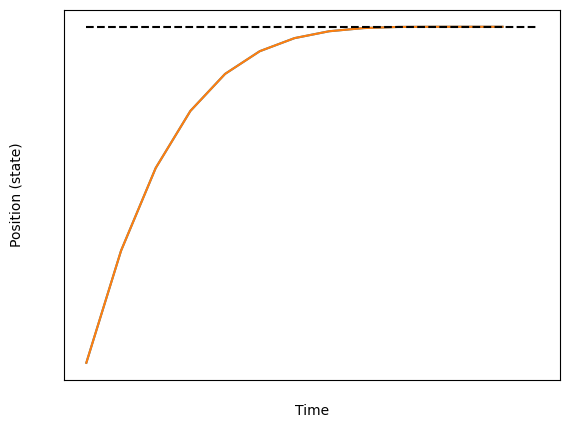

In [10]:
plt.plot(x_ff[0::nx])
plt.plot(X[:,0])
plt.hlines(y=0,xmin=0,xmax=len(X[:,0]),colors="black", linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Position (state)")
plt.tick_params(length=0)
plt.xticks(color="None")
plt.yticks(color="None")
plt.show()

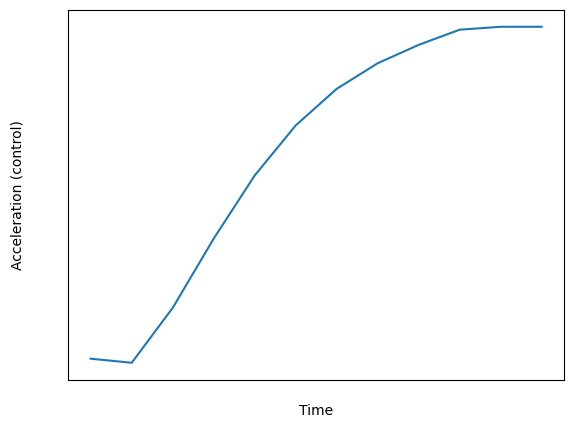

In [11]:
plt.plot(u_ff)
plt.xlabel("Time")
plt.ylabel("Acceleration (control)")
plt.tick_params(length=0)
plt.xticks(color="None")
plt.yticks(color="None")
plt.show()

# 外乱がある場合のフィード・フォワード制御

In [12]:
F = make_F()
X = [x_init]
U = []
x_current = x_init
x0 = casadi.DM.zeros(total)
for k in range(K):
    x_current = F(x=x_current,u=u_ff[k])["x_next"]
    if k==2:
        x_current[1] += 0.5
    X.append(x_current)
# X.pop()
X = np.array(X).reshape(K+1,nx)

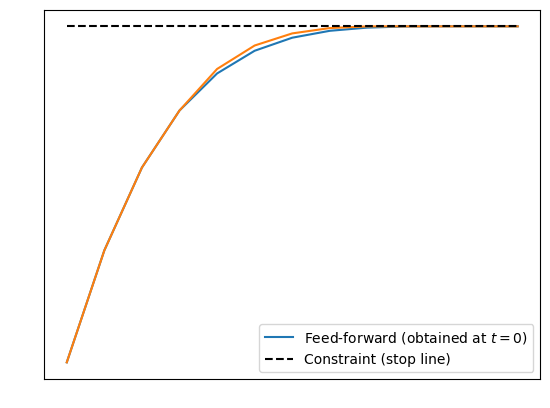

In [23]:
plt.plot(x_ff[0::nx], label="Feed-forward (obtained at $t=0$)")
plt.plot(X[:,0])
plt.hlines(y=0,xmin=0,xmax=len(X[:,0])-1,colors="black", linestyle='dashed', label="Constraint (stop line)")
plt.tick_params(length=0)
plt.legend()
plt.xticks(color="None")
plt.yticks(color="None")
plt.show()

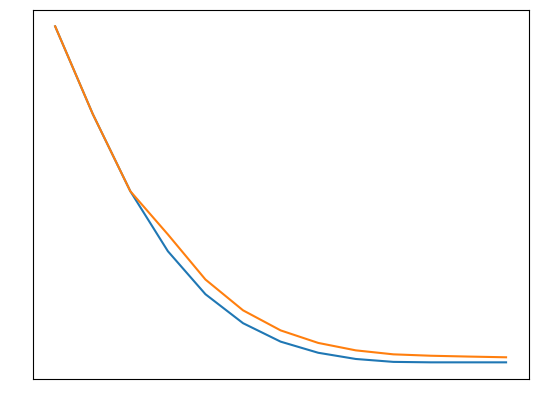

In [14]:
plt.plot(x_ff[1::nx])
plt.plot(X[:,1])
plt.tick_params(length=0)
plt.xticks(color="None")
plt.yticks(color="None")
plt.show()

# 外乱がある場合のMPC

In [15]:
F = make_F()
X = [x_init]
U = []
x_current = x_init
x0 = casadi.DM.zeros(total)
for k in range(K):
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = F(x=x_current,u=u_opt)["x_next"]
    if k==2:
        x_current[1] += 0.4
    X.append(x_current)
    U.append(u_opt)
X = np.array(X).reshape(K+1,nx)
U = np.array(U).reshape(K,nu)

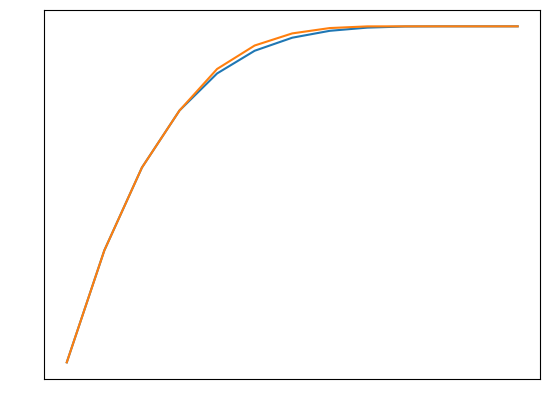

In [24]:
plt.plot(x_ff[0::nx])
plt.plot(X[:,0])
plt.tick_params(length=0)
plt.xticks(color="None")
plt.yticks(color="None")
plt.show()

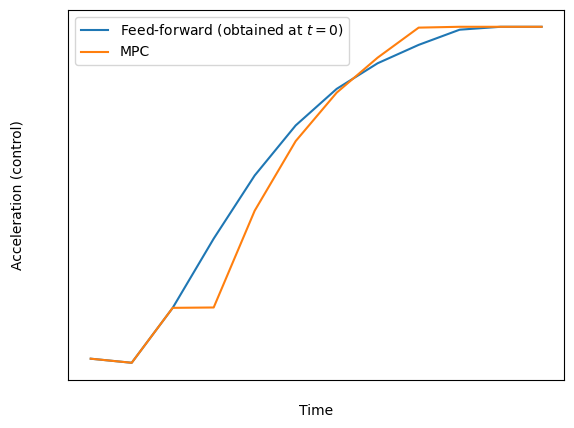

In [21]:
plt.plot(u_ff, label="Feed-forward (obtained at $t=0$)")
plt.plot(U, label="MPC ()")
plt.xlabel("Time")
plt.ylabel("Acceleration (control)")
plt.tick_params(length=0)
plt.xticks(color="None")
plt.yticks(color="None")
plt.legend()
plt.show()